# Problem 1: reading in excel data, munging it into dataframes, and plotting long term annual mean precip by water year with geopandas

In [2]:
import pandas as pd
import geopandas as gpd
import os
from shapely.geometry import Point
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# didn't use this function because of a problem with Pillow reading  some byte format
def add_basemap(ax, zoom, url='http://a.tile.stamen.com/terrain/{z}/{x}/{y}.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

def get_single_sheet(excel_obj, sheet_id, use_n_cols=8, skip_n_rows=9):
    """
    
    Reads in precip gauge data from sb_county. Defaults for cols and rows 
    used for reading in the daily data.
    
    """
    return excel_obj.parse(sheet_name=sheet_id, usecols=list(range(0,use_n_cols)), skiprows=list(range(0,skip_n_rows)))


This reads in a big excel file with multiple sheets, then applies a function to seperate the sheets so that we can make a dataframe with annual averages for the water year

In [3]:
stations_df = pd.read_excel("Precipitation_Data.xlsx")

xlsx = pd.ExcelFile("Precipitation_Data.xlsx")


sheets = []
for sheet in xlsx.sheet_names:
    if sheet != 'Stations':
        sheets.append(get_single_sheet(xlsx, sheet, 8, 9))

In [4]:
def longterm_mean_annual_precip(i):
    """Groups a sheet df by water year, takes the 
    sum of daily rainfall and then takes the mean 
    of the annual sums"""
    
    if 'water year' not in sheets[i]:
        sheets[i].rename(columns={'wy':"water year", 'dailyrain':"daily rain"}, inplace=True)
    return sheets[i].groupby('water year')['daily rain'].sum().mean()

longterm_means = []
for i, sheet in enumerate(sheets):
    longterm_means.append(longterm_mean_annual_precip(i))

Here we make the df from the list of long term annual means. We then associate this with the spatial data in the first sheet. This works because both lists (longterm_means and the stations_df Lon and Lat columns) are each ordered the same and of the same length

In [5]:
long_means_df = pd.DataFrame({'Long Term Annual Means':longterm_means})

long_means_df['Coordinates'] = list(zip(stations_df.Lon,stations_df.Lat))

long_means_df['Coordinates']=long_means_df['Coordinates'].apply(Point)

gdf_longterm_means = gpd.GeoDataFrame(long_means_df, geometry='Coordinates')
gdf_longterm_means.crs = {'init': 'epsg:4326'}

jalama_ws = gpd.read_file('JalamaWatershed.shp')
santa_ynez_ws = gpd.read_file('santa_ynez_watershed.shp')

santa_ynez_ws = santa_ynez_ws.to_crs(jalama_ws.crs)

Using zoom level 9, this will download 6 tiles


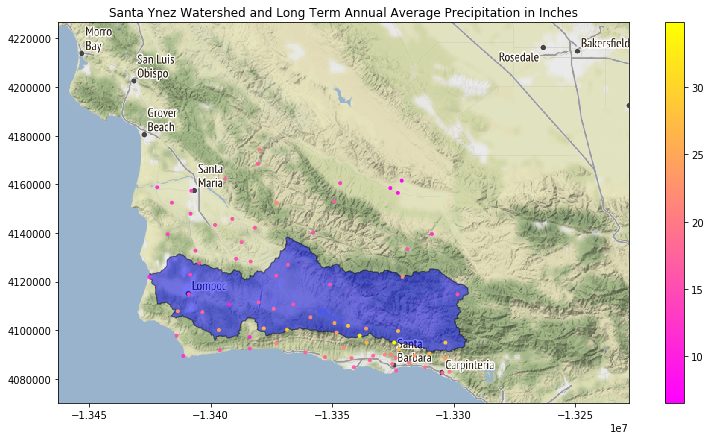

In [6]:
# this grabs a basemap tile from Stamen using contextily
w,s,e,n = gdf_longterm_means.total_bounds
_ = ctx.howmany(w, s, e, n, 9, ll=True)
img, ext = ctx.bounds2img(w, s, e, n, 9, ll=True)

f, ax = plt.subplots(1, figsize=(13,7))
ax.imshow(img, extent=ext)

santa_ynez_ws.to_crs(epsg=3857).plot(ax = ax, color = 'blue', edgecolor='black', alpha=0.5)
gdf_longterm_means.to_crs(epsg=3857).plot(ax = ax, marker = 'H', markersize = 10, column="Long Term Annual Means", cmap="spring" , legend = True)
plt.title("Santa Ynez Watershed and Long Term Annual Average Precipitation in Inches")
plt.savefig("Figure1_SantaYnez_and_LongTerm_Precip.png")

# Problem 2: regression of elevation and mean annual precip 

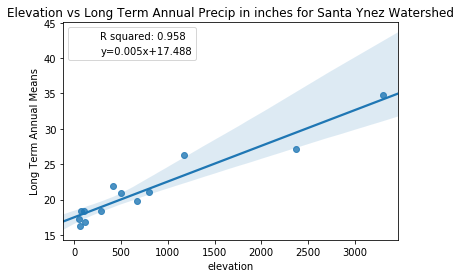

In [42]:
import seaborn as sns
from scipy import stats
from matplotlib.patches import Rectangle

gdf_longterm_means['In SB/Goleta Region?'] = stations_df['SB/Goleta Region']
gdf_longterm_means['elevation'] = stations_df['Elevation (ft above sea level)']

gdf_sb_precip = gdf_longterm_means[gdf_longterm_means['In SB/Goleta Region?'] == 'Y']
df = pd.DataFrame(gdf_sb_precip)

# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(list(df['elevation']), list(df['Long Term Annual Means']))

ax = sns.regplot(df['elevation'], df['Long Term Annual Means'], line_kws={'label':"y={0:.5f}x+{1:.3f}".format(slope,intercept)})
plt.title('Elevation vs Long Term Annual Precip in inches for Santa Ynez Watershed')
extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
ax.legend([extra, extra], (("R squared: {0:.3f}".format(r_value)), "y={0:.3f}x+{1:.3f}".format(slope,intercept)), loc=2)
plt.savefig("Figure2LongTerm_Precip_reg.png")

# Problem 3: Results for Santa Ynez Watershed

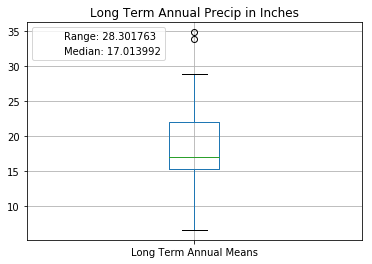

In [8]:
ax = long_means_df.boxplot('Long Term Annual Means')
plt.title("Long Term Annual Precip in Inches")
ax.legend([extra, extra], (("Range: {0:3f}".format(max(longterm_means)-min(longterm_means))), "Median: {0:3f}".format(np.median(longterm_means))), loc=2)

The above plot show the range, median, and box plot of long term annual means. Rainfall clearly varies quite a bit, with a range that is considerably larger than the median. About 96% of this variation is explained by elevation alone, indicating that over multi decadal time scales, the long term averages primarily vary due to the regional topography. Looking at the map of precipitation amount over all 80 of our rain gauges, it is clear that the highest long term annual averages are observed around the Santa Ynez mountains at higher elevations, the closer you get to Santa Barbara. This indicates that there is a rain shadow effect that is contributing to high precipitation at higher elevations on the wet side of the mountain, the side near the ocean. The lowlands north of the Santa Ynez mountains, both within and outside of Jalama watershed, are dry (most are below the median) because the santa ynez mountains block moist advection from the south and also experience hot northerly air from the Central Valley, leading to a drier climate. This is also true at the western edge of the Santa Ynez mountains, below and around Lompoc, where 5 gauges show precipitation values below ~15 inches. It looks like this could be due to a rain shadow effect as well, because a couple precipitation gauges north of the mountains show higher precipitation values (shown in orange) which indicate amounts above the median. It's also worth noting that coastal gauges out west near Cojo Bay exhibit low values.

# Problem 4. Total Catchement Area of Jalama Watershed with units

In [9]:
area_sqkm = santa_ynez_ws['geometry'].to_crs(epsg=3395).map(lambda p: p.area / 10**6)[0]
print("Area in Square Kilometers of the Santa Ynez Watershed: ", area_sqkm)

Area in Square Kilometers of the Santa Ynez Watershed:  3421.6409663012228


# Problem 5 Create Thiessen polygons for santa ynez watershed, make a map, create table detailing fraction of watershed that intersects each monitoring station's thiessen polygon, calculate estimate of mean annual precipitation in Santa Ynez watershed

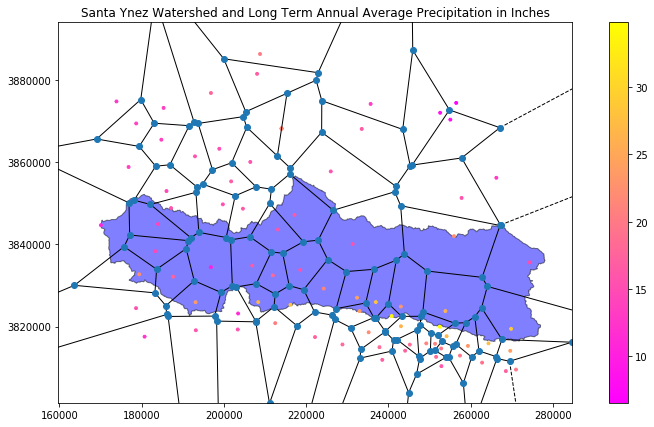

In [10]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Voronoi.html
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.voronoi_plot_2d.html

from scipy.spatial import Voronoi, voronoi_plot_2d

gdf_means_utm = gdf_longterm_means.to_crs(epsg=32611)

point_coords = [np.array((geom.xy[0][0], geom.xy[1][0])) for geom in gdf_means_utm.centroid]

vor = Voronoi(point_coords)

# # this grabs a basemap tile from Stamen using contextily
# w,s,e,n = gdf_longterm_means.total_bounds
# _ = ctx.howmany(w, s, e, n, 9, ll=True)
# img, ext = ctx.bounds2img(w, s, e, n, 9, ll=True)

f, ax = plt.subplots(1, figsize=(13,7))
# ax.imshow(img, extent=ext)
f = voronoi_plot_2d(vor, show_points=False, ax = ax)
santa_ynez_ws.to_crs(epsg=32611).plot(ax = ax, color = 'blue', edgecolor='black', alpha=0.5)
gdf_longterm_means.to_crs(epsg=32611).plot(ax = ax, marker = 'H', markersize = 10, column="Long Term Annual Means", cmap="spring" , legend = True)
plt.title("Santa Ynez Watershed and Long Term Annual Average Precipitation in Inches")
plt.savefig("Figure3_SantaYnez_and_Thiessen.png")
plt.show()

testing this new package that wraps the above scipy voronoi functions but integrates with shapely https://github.com/WZBSocialScienceCenter/geovoronoi

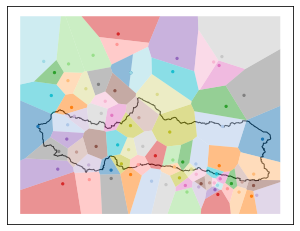

In [11]:
import shapely.geometry as shpgeo
import matplotlib.pyplot as plt
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords

area_shape = santa_ynez_ws.to_crs(epsg=3395).iloc[0].geometry
gdf_means = gdf_longterm_means.to_crs(epsg=3395)
buffered_box = shpgeo.box(*gdf_means.total_bounds).buffer(10000).bounds
buffered_box = shpgeo.box(*buffered_box)

point_coords = np.array([np.array((geom.xy[0][0], geom.xy[1][0])) for geom in gdf_means.centroid])
poly_shapes, pts, poly_to_pt_assignments = voronoi_regions_from_coords(point_coords, buffered_box)

fig, ax = subplot_for_map()
plot_voronoi_polys_with_points_in_area(ax, area_shape, poly_shapes, point_coords, poly_to_pt_assignments)
plt.show()

These are the fractional areas of the voronoi diagram that intersect the watershed. We need the whole polygons that are partially contained by the watershed so that we can associate the rain gauge values with them.

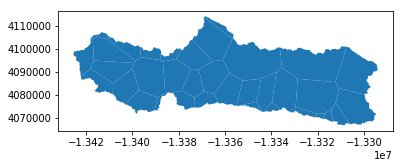

In [12]:
voronoi_gdf = gpd.GeoDataFrame().set_geometry(poly_shapes)
voronoi_gdf.crs = {'init' : 'epsg:3395'}

# to test multiple intersections, geodfs need to be same length or need to use shapely geometry
vor_intersections = voronoi_gdf.intersection(santa_ynez_ws.to_crs(epsg=3395).iloc[0]['geometry'])

vor_intersections.plot()

Plot of total voronoi polygons that intersect with watershed

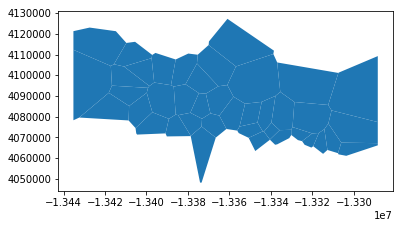

In [13]:
# only area contained within watershed
vor_areas = vor_intersections.area[vor_intersections.area > 0]
vor_intersections = vor_intersections[vor_intersections.area > 0]
whole_vor_intersections = voronoi_gdf[voronoi_gdf.index.isin(vor_intersections.index)]
whole_vor_intersections.plot()

Spatial join of whole polygons that intersect and rain gauge point data. Then we calculate the area fractions for the part of each voronoi polygon that intersects the watershed

In [14]:
gdf_longterm_means = gdf_longterm_means.to_crs(epsg = 3395)
joined_vors = gpd.sjoin(whole_vor_intersections, gdf_longterm_means)

joined_vors['area_intersects'] = vor_areas
sy_ws_mercator = santa_ynez_ws.to_crs(epsg=3395)
joined_vors['area_fraction'] = joined_vors['area_intersects'].apply(lambda x:x/sy_ws_mercator.area[0])

/home/rave/anaconda3/envs/geo/lib/python3.6/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


Table of fractional area for each station polygon that intersects the watershed

In [15]:
print('fractions sum to 1: '+ str(joined_vors['area_fraction'].sum()))
display(joined_vors)
print("Long Term Annual Mean Catchement Average Precip in the Santa Ynez Watershed in inches/year: ", np.sum(joined_vors['area_fraction']*joined_vors['Long Term Annual Means']))

fractions sum to 1: 1.0000000000000044


,geometry,index_right,Long Term Annual Means,In SB/Goleta Region?,elevation,area_intersects,area_fraction
0,POLYGON ((-13312377.36233869 4085676.031319601...,29,15.240000,NaN,4600,2.227689e+08,0.065106
1,POLYGON ((-13307475.86535888 4101112.178096304...,26,22.175113,NaN,6360,3.170455e+08,0.092659
2,POLYGON ((-13312377.36233869 4085676.031319601...,12,26.210202,NaN,1500,2.268513e+08,0.066299
3,POLYGON ((-13310765.09923213 4083045.676783952...,10,28.852174,NaN,2230,1.734253e+08,0.050685
10,POLYGON ((-13288473.74681064 4066212.622984712...,34,24.003483,NaN,1650,2.065872e+05,0.000060
11,POLYGON ((-13312307.41559261 4076712.190477004...,11,27.277558,NaN,1775,3.887978e+07,0.011363
16,"POLYGON ((-13338830.4128101 4110244.468598761,...",25,15.591504,NaN,1690,3.135827e+08,0.091647
17,"POLYGON ((-13338549.950599 4111860.053438161, ...",71,15.539091,NaN,1200,2.440318e+07,0.007132
21,POLYGON ((-13335477.10306894 4091956.983916337...,21,23.167500,NaN,1029,1.524668e+08,0.044560
24,POLYGON ((-13314238.25883644 4073995.703775476...,1,23.340000,NaN,519,1.341340e+07,0.003920


Long Term Annual Mean Catchement Average Precip in the Santa Ynez Watershed in inches/year:  19.42747838474743


# Problem 6 300 words on results

Text(0.5, 1.0, 'Thiessen polygon estimation of long term average precip per polygon')

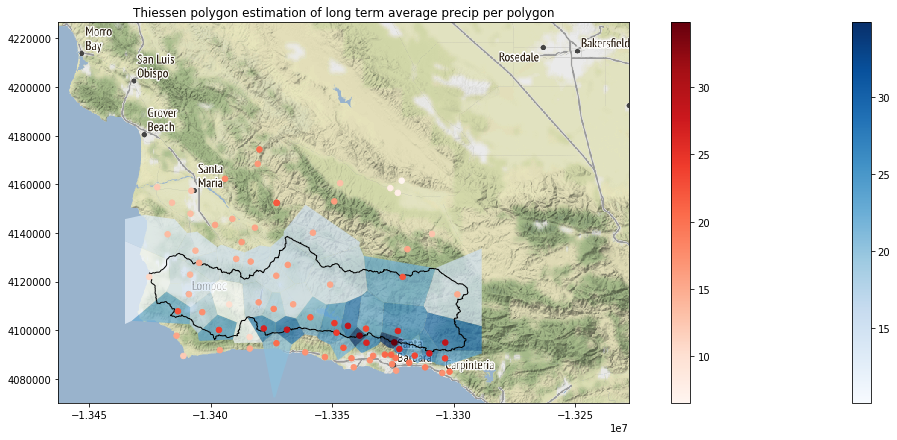

In [16]:
f, ax = plt.subplots(1, figsize=(19,7))

ax.imshow(img, extent=ext)
joined_vors.to_crs(epsg=3857).plot(ax=ax, column='Long Term Annual Means',  cmap="Blues" , legend=True, alpha=.7)

sy_ws_mercator.to_crs(epsg=3857).plot(ax = ax, color = 'none', edgecolor='black')
gdf_longterm_means.to_crs(epsg=3857).plot(ax = ax, marker = 'o', markersize = 30, column="Long Term Annual Means", cmap='Reds', legend=True)
plt.title("Thiessen polygon estimation of long term average precip per polygon: Santa Ynez Watershed")

Similar to what we saw with the point data, the Thiessen polygon estimation of long term average precipitation follow the topography of the Santa Ynez mountains. Generally, higher values are spatially estimated south of the mountains and at higher elevations within the range and lower values estimated north of the range closer to the central valley and central coast up near Lompoc. However, the sparseness of the point data results in some likely errors in the Thiessen estimation. For instance, the lack of points between santa barbara and the mountains at the northern end of the watershed results in the Thiessen polygon predictions being covering more latitudinal distance than they probably should, and it is likely that precip is over or underestimated near the north-south boundaries of these Thiessen polygons. 

In general, thiessen polygons are not physically or statistically based and do not account for the arrangement of topography, coastlines, and climate patterns that are at play in a location like the Santa Ynez watershed. Pardo-Iguzquiza 1998 did a comparison of methods for rainfall estimation using kriging that took orographic and rainfall data as inputs and Thiessen polygons with just rainfall data. He found that kriging performed better in this system, and concluded that this was mostly because of the high correlation between precipitation and altitude and because krigin accounts for spatial autocorrelation. However, Kriging would likely not perform as well in convection driven rainfall systems and Thiessen polygons might be an improvement if enough rain gauges were distributed over an area of interest (which is rarely the case I expect). 

The runoff ratio for the watershed is 1.7/19.427 = 8.75%
The low runoff ratio is likely because of infiltration, high rates of evapotranspiration, and human management of water (water is rerouted for drinking, etc.)

# Problem 7 Do Thiessen precip estimation again for Jalama, with 2 figures

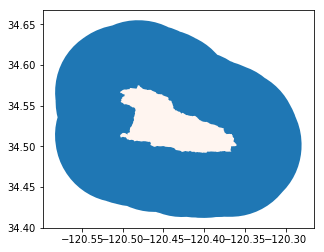

In [20]:
#buffer to subset the map
ax = jalama_ws.buffer(.08).plot()
jalama_ws.plot(ax=ax, cmap='Reds')

Our clipped thiessen polygons don't overlap the Jalama so we need to subset again.

Using zoom level 10, this will download 2 tiles


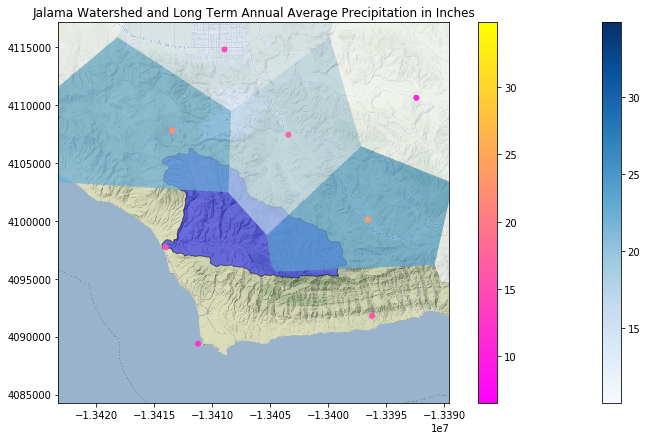

In [24]:
# this grabs a basemap tile from Stamen using contextily
jalama_buffer = jalama_ws.buffer(.08)
w,s,e,n = jalama_buffer.total_bounds
_ = ctx.howmany(w, s, e, n, 10, ll=True)
img, ext = ctx.bounds2img(w, s, e, n, 12, ll=True)

f, ax = plt.subplots(1, figsize=(13,7))
ax.imshow(img, extent=ext)

jalama_ws.to_crs(epsg=3857).plot(ax = ax, color = 'blue', edgecolor='black', alpha=0.5)

gdf_longterm_means.to_crs(epsg=3857).plot(ax = ax, marker = 'H', markersize = 30, column="Long Term Annual Means", cmap="spring" , legend = True)
plt.title("Jalama Watershed and Long Term Annual Average Precipitation in Inches")
plt.savefig("Figure4_Jalama_and_LongTerm_Precip.png")
plt.xlim([jalama_buffer.to_crs(epsg=3857).geometry.bounds.minx.min()-.05, jalama_buffer.to_crs(epsg=3857).geometry.bounds.maxx.max()+.05])
plt.ylim([jalama_buffer.to_crs(epsg=3857).geometry.bounds.miny.min()-.05, jalama_buffer.to_crs(epsg=3857).geometry.bounds.maxy.max()+.05]);

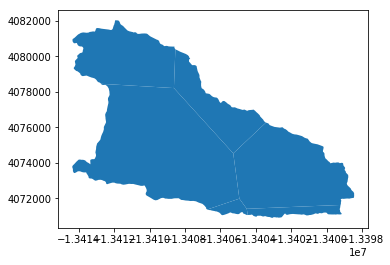

In [27]:
voronoi_gdf = gpd.GeoDataFrame().set_geometry(poly_shapes)
voronoi_gdf.crs = {'init' : 'epsg:3395'}

# to test multiple intersections, geodfs need to be same length or need to use shapely geometry
vor_intersections = voronoi_gdf.intersection(jalama_ws.to_crs(epsg=3395).iloc[0]['geometry'])

vor_intersections.plot()

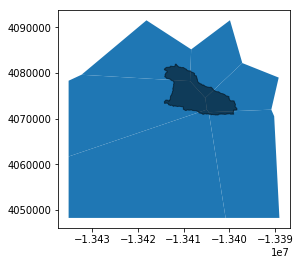

In [34]:
# only area contained within watershed
vor_areas = vor_intersections.area[vor_intersections.area > 0]
vor_intersections = vor_intersections[vor_intersections.area > 0]
whole_vor_intersections = voronoi_gdf[voronoi_gdf.index.isin(vor_intersections.index)]

ax= whole_vor_intersections.plot()
jalama_ws.to_crs(epsg=3395).plot(ax=ax, color = 'black', edgecolor='black', alpha=0.5)

fractions sum to 1: 1.0000000000000007


/home/rave/anaconda3/envs/geo/lib/python3.6/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


,geometry,index_right,Long Term Annual Means,In SB/Goleta Region?,elevation,area_intersects,area_fraction
26,"POLYGON ((-13435223.35591108 4061689.73855421,...",56,12.238846,NaN,80,1.118161e+06,0.011961
27,"POLYGON ((-13400821.94729663 4048238.43847302,...",40,15.874545,NaN,150,2.424181e+06,0.025931
28,POLYGON ((-13404928.96900388 4071972.940577496...,50,15.540190,NaN,50,4.082642e+07,0.436717
29,POLYGON ((-13404511.52860328 4071398.083685166...,64,23.792405,NaN,640,2.319466e+07,0.248112
71,"POLYGON ((-13397163.6429273 4082167.041363128,...",79,17.484493,NaN,270,1.025256e+07,0.109671
74,POLYGON ((-13408364.19536283 4085169.870242986...,0,22.533329,NaN,925,1.566880e+07,0.167608


Long Term Annual Mean Catchement Average Precip in the Santa Ynez Watershed in inches/year:  18.94218302661117


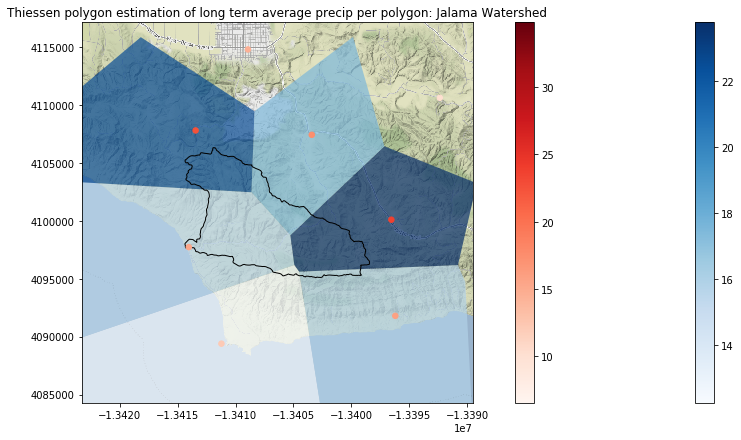

In [39]:
gdf_longterm_means = gdf_longterm_means.to_crs(epsg = 3395)
joined_vors = gpd.sjoin(whole_vor_intersections, gdf_longterm_means)

joined_vors['area_intersects'] = vor_areas
jalama_mercator = jalama_ws.to_crs(epsg=3395)
joined_vors['area_fraction'] = joined_vors['area_intersects'].apply(lambda x:x/jalama_mercator.area[0])
print('fractions sum to 1: '+ str(joined_vors['area_fraction'].sum()))
display(joined_vors)
print("Long Term Annual Mean Catchement Average Precip in the Santa Ynez Watershed in inches/year: ", np.sum(joined_vors['area_fraction']*joined_vors['Long Term Annual Means']))

f, ax = plt.subplots(1, figsize=(19,7))

ax.imshow(img, extent=ext)
joined_vors.to_crs(epsg=3857).plot(ax=ax, column='Long Term Annual Means',  cmap="Blues" , legend=True, alpha=.7)

jalama_mercator.to_crs(epsg=3857).plot(ax = ax, color = 'none', edgecolor='black')
gdf_longterm_means.to_crs(epsg=3857).plot(ax = ax, marker = 'o', markersize = 30, column="Long Term Annual Means", cmap='Reds', legend=True)
plt.title("Thiessen polygon estimation of long term average precip per polygon: Jalama Watershed")
plt.xlim([jalama_buffer.to_crs(epsg=3857).geometry.bounds.minx.min()-.05, jalama_buffer.to_crs(epsg=3857).geometry.bounds.maxx.max()+.05])
plt.ylim([jalama_buffer.to_crs(epsg=3857).geometry.bounds.miny.min()-.05, jalama_buffer.to_crs(epsg=3857).geometry.bounds.maxy.max()+.05]);
plt.savefig("Figure5VoronoiJalama.png")

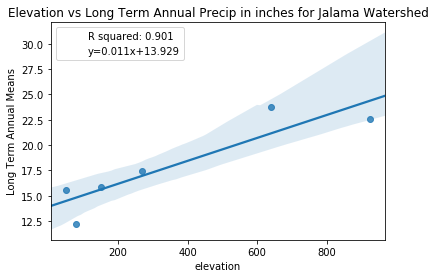

In [43]:
# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(list(joined_vors['elevation']), list(joined_vors['Long Term Annual Means']))

ax = sns.regplot(joined_vors['elevation'], joined_vors['Long Term Annual Means'], line_kws={'label':"y={0:.5f}x+{1:.3f}".format(slope,intercept)})
plt.title('Elevation vs Long Term Annual Precip in inches for Jalama Watershed')
extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
ax.legend([extra, extra], (("R squared: {0:.3f}".format(r_value)), "y={0:.3f}x+{1:.3f}".format(slope,intercept)), loc=2)
plt.savefig("Figure6LongTerm_Precip_reg_jalama.png")

I used the same methodlogy as I used for the Santa Ynez watershed, though I think it is hard to justify one method over another given the sparsity of data and that we are not incorporating topography. The Jalama is a more difficult watershed to estimate precip (with just the county data) because the gauges are almost all outside of the watershed and are spaced nearly equidistant around the watershed's boundaries, leaving more length of biased boundaries between estimated precip levels within the watershed. Elevation correlates well with precipitation just like in the Santa Ynez watershed, likely because of rainshadow effects, causing rainout at higher elevtions to the north, leaving less rain towards the south. The rain gauges show what one might expect given the rainshadow effect, but its difficult to say if the Thiessen polygons accurately represent rainfall patterns within the watershed, since the watershed spans high and low elevations with pretty complex topography. It's also difficult to say if the high rainfall rates measured by the gauges to the north east of the watershed are representative of the rainfall in Jalama, given that there is a considerable amount of high elevation between the gauges and Jalama, possibly intercepting moist advection on average.